In [15]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

Please reference [this link](https://www.goodmedicine.org.uk/files/assessment,%20pittsburgh%20psqi.pdf) for scoring details.

## Response Scoring Example

### Form A

Example data:

In [16]:
example_response_data = pd.read_csv("./responses/form_a.csv")
example_response_data = example_response_data.set_axis(
    [
        "timestamp", "participant_ID", "participant_gender", "participant_age", "participant_occupation",
        "q1", "q2", "q3", "q4", "q5a", "q5b", "q5c", "q5d", "q5e", "q5f", "q5g", "q5h", "q5i", "q5j_text", "q5j_freq",
        "q6", "q7", "q8", "q9"
    ],
    axis=1
)
example_response_data

,timestamp,participant_ID,participant_gender,participant_age,participant_occupation,q1,q2,q3,q4,q5a,...,q5f,q5g,q5h,q5i,q5j_text,q5j_freq,q6,q7,q8,q9
0,10/19/2023 16:21:11,22-T-09-JKT,Female,20,Undergraduate Student,1:00:00 AM,20,9:00:00 AM,6.0,Once or twice a week,...,Not during the past month,Not during the past month,Less than once a week,Once or twice a week,NaN,NaN,Fairly good,Not during the past month,Less than once a week,Only a very slight problem
1,10/19/2023 16:41:48,22-C-17-JAK,Male,21,Undergraduate Student,1:00:00 AM,30,10:00:00 AM,7.5,Less than once a week,...,Not during the past month,Not during the past month,Once or twice a week,Not during the past month,NaN,Less than once a week,Fairly good,Not during the past month,Not during the past month,Only a very slight problem
2,10/19/2023 17:57:05,22-K-06-JAK,Female,21,Undergraduate Student,2:30:00 AM,30,10:00:00 AM,7.0,Once or twice a week,...,Not during the past month,Three or more times a week,Once or twice a week,Less than once a week,NaN,NaN,Fairly good,Not during the past month,Not during the past month,A very big problem
3,10/19/2023 18:28:55,22-J-13-SUR,Female,21,Undergraduate Student,12:00:00 PM,20,6:20:00 AM,6.0,Once or twice a week,...,Not during the past month,Not during the past month,Less than once a week,Not during the past month,NaN,Once or twice a week,Fairly good,Not during the past month,Not during the past month,No problem at all
4,10/19/2023 20:25:49,22-M-24-LOS,Female,21,Undergraduate Student,2:00:00 AM,30,10:00:00 AM,7.0,Three or more times a week,...,Less than once a week,Once or twice a week,Not during the past month,Not during the past month,NaN,NaN,Fairly good,Not during the past month,Not during the past month,Only a very slight problem
5,10/23/2023 22:09:37,23-C-23-TOR,Female,22,Undergraduate Student,12:30:00 AM,70,8:00:00 AM,6.8,Once or twice a week,...,Once or twice a week,Less than once a week,Not during the past month,Less than once a week,NaN,NaN,Fairly good,Not during the past month,Less than once a week,Somewhat of a problem
6,10/25/2023 22:36:17,NaN,Female,22,Undergraduate Student,1:00:00 AM,10,11:00:00 AM,9.0,Not during the past month,...,Less than once a week,Not during the past month,Not during the past month,Not during the past month,NaN,Not during the past month,Fairly good,Not during the past month,Not during the past month,Somewhat of a problem
7,10/25/2023 22:36:58,NaN,Female,22,Undergraduate Student,2:30:00 AM,15,9:00:00 AM,7.0,Not during the past month,...,Not during the past month,Not during the past month,Not during the past month,Not during the past month,NaN,NaN,Fairly good,Not during the past month,Less than once a week,Only a very slight problem
8,10/25/2023 22:45:49,NaN,Male,22,Undergraduate Student,11:00:00 PM,420,9:00:00 AM,7.0,Once or twice a week,...,Not during the past month,Not during the past month,Less than once a week,Not during the past month,NaN,Not during the past month,Fairly good,Not during the past month,Not during the past month,No problem at all
9,10/25/2023 22:46:54,23-M-,Male,21,Undergraduate Student,12:00:00 AM,7,8:30:00 AM,8.0,Not during the past month,...,Less than once a week,Less than once a week,Once or twice a week,Not during the past month,nothing,Not during the past month,Fairly good,Not during the past month,Not during the past month,No problem at all


#### Component Score Computation

In [17]:
def get_component_1(response_df, categorical_map):
    return response_df["q6"].replace(categorical_map["q6"])

In [18]:
def get_component_2(response_df, categorical_map):
    def process_q2(num):
        num = float(num)
        assert num >= 0, "q2 response must be nonnegative"
        if num <= 30:
            return num // 15
        else:
            return min(2, num // 30) + 1
    q5a_numerical = response_df["q5a"].replace(categorical_map["q5"])
    sum_of_parts = q5a_numerical + response_df["q2"].apply(process_q2)
    return sum_of_parts.apply(lambda x: min(3, (x + 1) // 2))

In [19]:
def get_component_3(response_df, categorical_map):
    def process_q3(num):
        num = float(num)
        if num > 7: return 0
        elif 6 <= num <= 7: return 1
        elif 5 <= num < 6: return 2
        else: return 3
    return response_df["q4"].apply(process_q3)

In [20]:
def get_component_4(response_df, categorical_map):
    def intify_time_str(time_str):
        split_time_str = time_str[:time_str.index(" ")].split(":")
        return float(split_time_str[0]) * 60 ** 2 + float(split_time_str[1]) * 60 + float(split_time_str[2])
        
    def get_time_difference(period_start, period_end):
        time_start, time_end = intify_time_str(period_start), intify_time_str(period_end)
        if time_end < time_start:
            return time_end + 24 * 60 ** 2 - time_start
        else:
            return time_start - time_end
    
    def efficiency_to_score(eff):
        if eff > 0.85: return 0
        elif 0.75 <= eff <= 0.85: return 1
        elif 0.65 <= eff < 0.75: return 2
        else: return 3
    
    time_slept = response_df["q4"]
    time_on_bed = pd.Series(
        [
            get_time_difference(interval_start, interval_end)
            for interval_start, interval_end in zip(response_df["q1"], response_df["q3"])
        ]
    )
    habitual_sleep_efficiency = time_slept / time_on_bed
    return habitual_sleep_efficiency.apply(efficiency_to_score)

In [21]:
def get_component_5(response_df, categorical_map):
    def sum_component_score_map(score):
        return min(3, (score + 1) // 9)
        
    numerical_responses_q5 = [
        response_df[q5_subpart].replace(categorical_map["q5"])
        for q5_subpart in ["q5b", "q5c", "q5d", "q5e", "q5f", "q5g", "q5h", "q5i", "q5j_freq"]
    ]
    sum_of_q5_subparts = sum(numerical_responses_q5)
    return sum_of_q5_subparts.apply(sum_component_score_map)

In [22]:
def get_component_6(response_df, categorical_map):
    return response_df["q7"].replace(categorical_map["q7"])

In [23]:
def get_component_7(response_df, categorical_map):
    q8_numerical = response_df["q8"].replace(categorical_map["q8"])
    q9_numerical = response_df["q9"].replace(categorical_map["q9"])
    sum_of_parts = q8_numerical + q9_numerical
    return sum_of_parts.apply(lambda x: min(3, (x + 1) // 2))

#### Scoring

In [24]:
with open("./categorical_response_map.json") as f:
    categorical_map = json.load(f)

In [25]:
def master_scoring(response_df, categorical_map):
    response_df["c1"] = get_component_1(response_df, categorical_map)
    response_df["c2"] = get_component_2(response_df, categorical_map)
    response_df["c3"] = get_component_3(response_df, categorical_map)
    response_df["c4"] = get_component_4(response_df, categorical_map)
    response_df["c5"] = get_component_5(response_df, categorical_map)
    response_df["c6"] = get_component_6(response_df, categorical_map)
    response_df["c7"] = get_component_7(response_df, categorical_map)
    return sum(
        [response_df[f"c{cno}"] for cno in range(1, 8)]
    )

In [26]:
example_response_data["PSQI"] = master_scoring(example_response_data, categorical_map["form_a"])
example_response_data[["participant_ID", "PSQI"]]

,participant_ID,PSQI
0,22-T-09-JKT,11.0
1,22-C-17-JAK,7.0
2,22-K-06-JAK,12.0
3,22-J-13-SUR,7.0
4,22-M-24-LOS,12.0
5,23-C-23-TOR,13.0
6,NaN,5.0
7,NaN,10.0
8,NaN,8.0
9,23-M-,4.0


In [27]:
def export_form_responses(form_id):
    example_response_data_b = pd.read_csv(f"./responses/form_{form_id}.csv")
    if form_id != "a":
        example_response_data_b = example_response_data_b.set_axis(
            [
                "timestamp", "participant_ID",
                "q1", "q2", "q3", "q4", "q5a", "q5b", "q5c", "q5d", "q5e", "q5f", "q5g", "q5h", "q5i", "q5j_text", "q5j_freq",
                "q6", "q7", "q8", "q9"
            ],
            axis=1
        )
    else:
        example_response_data_b = example_response_data_b.set_axis(
            [
                "timestamp", "participant_ID", "participant_gender", "participant_age", "participant_occupation",
                "q1", "q2", "q3", "q4", "q5a", "q5b", "q5c", "q5d", "q5e", "q5f", "q5g", "q5h", "q5i", "q5j_text", "q5j_freq",
                "q6", "q7", "q8", "q9"
            ],
            axis=1
        )
    example_response_data_b["PSQI"] = master_scoring(example_response_data_b, categorical_map[f"form_{form_id}"])
    example_response_data_b["participant_ID"] = example_response_data_b["participant_ID"].str.upper()
    example_response_data_b[["participant_ID", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "PSQI"]]
    example_response_data_b[["participant_ID", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "PSQI"]].to_csv(f"./exported-PSQI-{form_id}.csv")
    return example_response_data_b

In [28]:
example_response_data_a = export_form_responses("a")
example_response_data_b = export_form_responses("b")
example_response_data_c = export_form_responses("c")

Text(0, 0.5, 'PSQI Index')

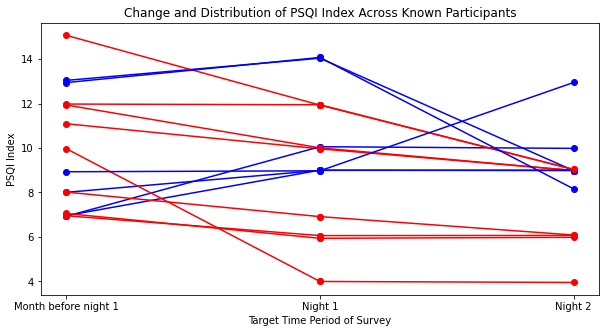

In [31]:
PSQI_complex = pd.merge(
    left=example_response_data[["participant_ID", "PSQI"]],
    right=example_response_data_b[["participant_ID", "PSQI"]],
    left_on="participant_ID",
    right_on="participant_ID",
    suffixes=("_month_of_night_1", "at_night_1")
)
PSQI_complex = pd.merge(
    left=PSQI_complex,
    right=example_response_data_c[["participant_ID", "PSQI"]],
    left_on="participant_ID",
    right_on="participant_ID"
).rename(columns={"PSQI": "PSQI_at_night_2"})
PSQI_complex.iloc[:, 1:] += np.random.normal(0, 0.05, (PSQI_complex.shape[0], 3))

fig, ax = plt.subplots(figsize=(10, 5))
for entry_id in range(PSQI_complex.shape[0]):
    line_color = "blue" if PSQI_complex.iloc[entry_id, 1] < PSQI_complex.iloc[entry_id, 2] else "red"
    plt.plot(
        [0, 1],
        [PSQI_complex.iloc[entry_id, 1], PSQI_complex.iloc[entry_id, 2]],
        marker="o",
        color=line_color
    )
    plt.plot(
        [1, 2],
        [PSQI_complex.iloc[entry_id, 2], PSQI_complex.iloc[entry_id, 3]],
        marker="o",
        color=line_color
    )
    plt.xticks([0, 1, 2], ["Month before night 1", "Night 1", "Night 2"])
plt.title("Change and Distribution of PSQI Index Across Known Participants")
plt.xlabel("Target Time Period of Survey")
plt.ylabel("PSQI Index")

In [43]:
(example_response_data_a["PSQI"] > 9).sum()

10

In [34]:
example_response_data_b["PSQI"].describe()

count    20.000000
mean      9.000000
std       3.026201
min       3.000000
25%       6.750000
50%       9.000000
75%      10.500000
max      14.000000
Name: PSQI, dtype: float64

In [35]:
example_response_data_c["PSQI"].describe()

count    15.000000
mean      8.466667
std       2.231805
min       4.000000
25%       7.000000
50%       9.000000
75%       9.000000
max      13.000000
Name: PSQI, dtype: float64